In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
db = mysql.connector.connect(host = 'localhost',
                              user = 'root',
                              password = '123456',
                              database = 'pizzahut')
cur = db.cursor()

# Retrieve the total number of orders placed.

In [2]:
query = """ select count(order_id) from orders """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ['Total Orders'])
print(df)

   Total Orders
0         21350


# Find The Second Highest Price Of A Pizza

In [14]:
query = """ select max(pizzas.price) as sec_max from pizzas
where pizzas.price < (select max(pizzas.price) from pizzas)"""
cur.execute(query);
data = cur.fetchall();
df = pd.DataFrame(data);
df

,0
0,25.5


# Calculate the total revenue generated from pizza sales.

In [3]:
query = """ select round(sum(price * order_details.quantity),2) from pizzas
join order_details
on order_details.pizza_id = pizzas.pizza_id """
cur.execute(query)
data = cur.fetchall()
data[0][0]

817860.05

# Identify the highest-priced pizza.

In [4]:
query = """ select pizza_types.name, price from pizzas
join pizza_types
on pizzas.pizza_type_id = pizza_types.pizza_type_id
order by pizzas.price desc limit 1 """
cur.execute(query)
data = cur.fetchall()
data[0][0]

'The Greek Pizza'

# Identify the lowest-priced pizza.

In [5]:
query = """ select pizza_types.name, price from pizzas
join pizza_types
on pizzas.pizza_type_id = pizza_types.pizza_type_id
order by pizzas.price asc limit 1 """
cur.execute(query)
data = cur.fetchall()
data[0][0]

'The Pepperoni Pizza'

# Identify the most common pizza size ordered.

  pizza size  ordered num
0          L        18526
1          M        15385
2          S        14137
3         XL          544
4        XXL           28


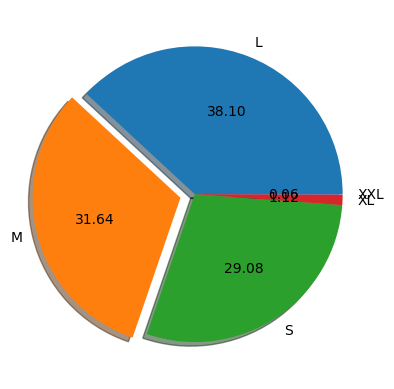

In [6]:
query = """ select size, count(quantity) as count from pizzas
join order_details
on order_details.pizza_id = pizzas.pizza_id
group by pizzas.size
order by count desc """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ['pizza size', 'ordered num'])
print(df)
ex = [0,0.1,0,0,0]
plt.pie(x = df['ordered num'], labels = df['pizza size'], autopct = "%.2f", explode = ex, shadow=True)
plt.show()

# List the top 10 most ordered pizza types along with their quantities.

                     pizza name qty ord
0      The Classic Deluxe Pizza    2453
1    The Barbecue Chicken Pizza    2432
2            The Hawaiian Pizza    2422
3           The Pepperoni Pizza    2418
4        The Thai Chicken Pizza    2371
5  The California Chicken Pizza    2370
6            The Sicilian Pizza    1938
7       The Spicy Italian Pizza    1924
8   The Southwest Chicken Pizza    1917
9            The Big Meat Pizza    1914


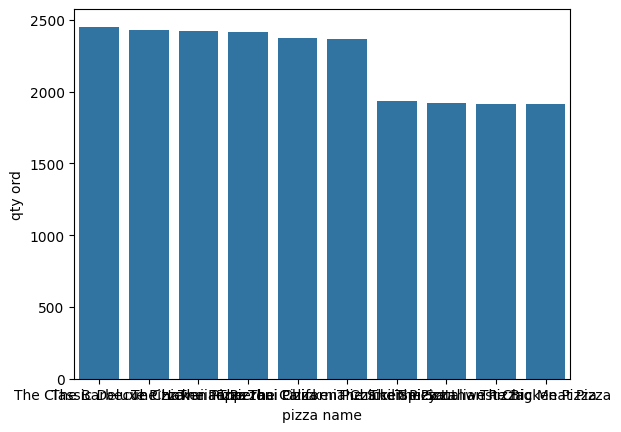

In [7]:
query = """ select pizza_types.name, sum(order_details.quantity) as 'ordered' from pizza_types
join pizzas
on pizza_types.pizza_type_id = pizzas.pizza_type_id
join order_details
on order_details.pizza_id = pizzas.pizza_id
group by pizza_types.name
order by ordered desc limit 10 """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ['pizza name', 'qty ord'])
print(df)
sns.barplot(data = df, x = 'pizza name', y = 'qty ord', )
plt.show()

# Join the necessary tables to find the total quantity of each pizza category ordered.

In [8]:
query = """ select pizza_types.category, sum(order_details.quantity) from pizza_types
join pizzas
on pizza_types.pizza_type_id = pizzas.pizza_type_id
join order_details
on pizzas.pizza_id = order_details.pizza_id
group by pizza_types.category """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ['category', 'quantity order'])
df

,category,quantity order
0,Classic,14888
1,Veggie,11649
2,Supreme,11987
3,Chicken,11050


# Determine the distribution of orders by hour of the day.

In [9]:
query = """ select hour(orders.time), count(orders.order_id) as order_count from orders
group by hour(orders.time) """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ['order/hours', 'quantity order'])
print(df)

    order/hours  quantity order
0            11            1231
1            12            2520
2            13            2455
3            14            1472
4            15            1468
5            16            1920
6            17            2336
7            18            2399
8            19            2009
9            20            1642
10           21            1198
11           22             663
12           23              28
13           10               8
14            9               1


# Join relevant tables to find the category-wise distribution of pizzas.

In [10]:
query = """ select pizza_types.category, count(pizza_types.name), round(sum(pizzas.price),2) 
from pizza_types
join pizzas
group by pizza_types.category """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ['pizza category', 'quantity pizza', 'Total Price'])
df

,pizza category,quantity pizza,Total Price
0,Veggie,864,14204.7
1,Supreme,864,14204.7
2,Classic,768,12626.4
3,Chicken,576,9469.8


# Group the orders by date and calculate the average number of pizzas ordered per day.

In [11]:
query = """ select round(avg(quantity),2) from 
        (select orders.date, count(order_details.quantity) as quantity from orders
        join order_details 
        on order_details.order_id = orders.order_id
        group by orders.date) as a """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=['avg order/day'])
df

,avg order/day
0,135.81


# Determine the top 3 most ordered pizza types based on revenue.

In [12]:
query = """ select pizza_types.name, round(sum(pizzas.price * order_details.quantity),2) as revenue from pizza_types
join pizzas
on pizzas.pizza_type_id = pizza_types.pizza_type_id
join order_details
on order_details.pizza_id = pizzas.pizza_id
group by pizza_types.name
order by revenue desc limit 5 """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=['pizza name', 'revenue'])
df

,pizza name,revenue
0,The Thai Chicken Pizza,43434.25
1,The Barbecue Chicken Pizza,42768.00
2,The California Chicken Pizza,41409.50
3,The Classic Deluxe Pizza,38180.50
4,The Spicy Italian Pizza,34831.25


# Calculate the percentage contribution of each pizza type to total revenue.

In [13]:
query = """ select pizza_types.category, 
    round(
        sum(pizzas.price * order_details.quantity) / 
        (select sum(pizzas.price * order_details.quantity) 
         from pizzas
         join order_details
         on order_details.pizza_id = pizzas.pizza_id) * 100, 2
    ) as revenue
from 
    pizza_types
join pizzas
    on pizzas.pizza_type_id = pizza_types.pizza_type_id
join order_details
    on order_details.pizza_id = pizzas.pizza_id
group by 
    pizza_types.category
order by 
    revenue desc """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=['pizza category', 'rev percentage'])
df

,pizza category,rev percentage
0,Classic,26.91
1,Supreme,25.46
2,Chicken,23.96
3,Veggie,23.68


In [ ]:
query = """"""